In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
import math
import time

In [2]:
def prepare_data(data, sequence_length=12, train_test_split=.75):
    # data is a list
    data_normalized = scaler.fit_transform(np.array(data).reshape(-1, 1)).flatten()

    # sequence_length=12 means use past 12 hours of data to predict the next hour
    # data_X is a list of subsequences of length sequence_length.
    # data_y has the real target value that comes immedietly after the corresponding subsequence in data_X
    # LSTM model is trying to predict the ith value of data_y based on the ith subsequence in data_X
    # doing this is what allows the model to find patterns in the data
    data_X, data_y = [], []
    for i in range(len(data_normalized) - sequence_length):
        data_X.append(data_normalized[i:i+sequence_length])
        data_y.append(data_normalized[i+sequence_length])

    # convert python lists to numpy ndarrays
    data_X = np.array(data_X)
    data_y = np.array(data_y)

    # convert ndarrays to tensors, needed for pytorch
    X = torch.tensor(data_X, dtype=torch.float32)
    y = torch.tensor(data_y, dtype=torch.float32)

    # split data into train and test
    split = math.floor(len(X) * train_test_split)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # reshape data for LSTM model
    X_train = X_train.view(-1, sequence_length, 1)
    X_test = X_test.view(-1, sequence_length, 1)

    # prepare output
    train_loader = (X_train, y_train)
    test_loader = (X_test, y_test)
    return train_loader, test_loader, split, sequence_length

In [3]:
# Define LSTM Model

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size  # I found the optimal hidden layer size to be 50 (tested 50, 75, 100)
        # defining the different layers of the LSTM model
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        # specifies how each pass through the model works
        # Pytorch does this for me when the model is training, which is why it is never called explicitly in the code.
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [4]:
def Training(model, optimizer, train_loader, num_epochs=20):
    start = time.time()
    loss_function = nn.MSELoss()
    # MSE loss makes the most sense imo

    for i in range(num_epochs):
        for seq, labels in zip(train_loader[0], train_loader[1]):
            optimizer.zero_grad()         # reset gradient from pervious iterations

            # reset hidden layer
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)           # performs prediction on seq using the model
            single_loss = loss_function(y_pred, labels)     # calculate mse
            single_loss.backward()        # backpropogation
            optimizer.step()              # update optimizer weights

        if i%3 == 0:
            print("epoch: {:3} loss: {:10.8f} time elapsed: {}".format(
                i, single_loss.item(), time.time()-start))

    return model

In [5]:
def Testing(model, test_loader, split, sequence_length):
    model.eval()
    y_pred = []
    for seq in test_loader[0]:  # Iter over the test loader
        with torch.no_grad():
            # reset the hidden layer for each seq, then append predicted value to y_pred
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            y_pred.append(model(seq).item())

    # transform y_pred to be similar to y_test
    y_pred_trans = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
    y_test = test_loader[1]

    # calculate and return the RMSE value, then plot the predicted and real values for the testing data
    mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_trans)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)

    plt.figure(figsize=(15, 6))
    plt.plot(timestamps[split+sequence_length:], y_pred_trans, label='Predicted')
    plt.plot(timestamps[split+sequence_length:], scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(), label='Real')
    plt.xlabel('Timestamp')
    plt.ylabel('CPU Usage')
    plt.title('Real vs Predicted CPU Usage')
    plt.legend()
    plt.savefig("Real_Pred_Graph")
    plt.show()

    return rmse

In [6]:
df = pd.read_csv('by_half_hour.csv',  parse_dates=True)
timestamps = df["Timestamp"].tolist()
cpu_data = df["Avg_CPU_95"].tolist()

# MinMaxScaler scales the data so that it is all within the range of (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00751994 time elapsed: 2.2715041637420654
epoch:   3 loss: 0.00356296 time elapsed: 8.861010074615479
epoch:   6 loss: 0.00166544 time elapsed: 15.496869325637817
epoch:   9 loss: 0.00075915 time elapsed: 21.708585739135742
epoch:  12 loss: 0.00032178 time elapsed: 28.48772168159485
epoch:  15 loss: 0.00014664 time elapsed: 34.48736619949341
epoch:  18 loss: 0.00007202 time elapsed: 41.42072367668152
RMSE:  0.4333244552919063


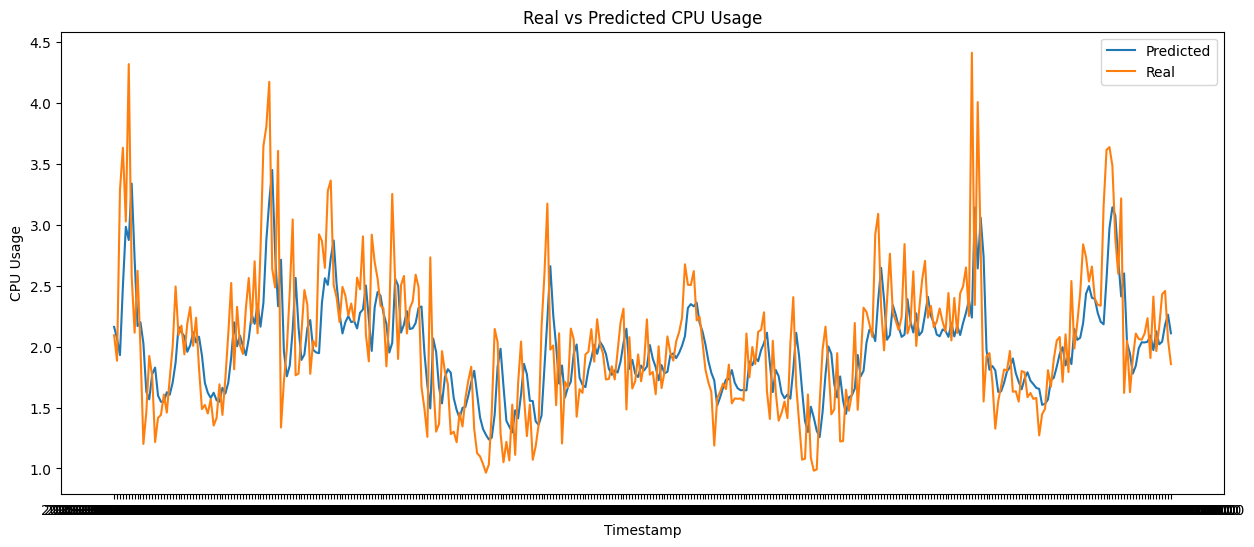

rmse:  0.4333244552919063


In [7]:
train, test, split, sequence_length = prepare_data(cpu_data)
model = LSTMModel(hidden_layer_size=50)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

result = Training(model, optimizer, train)
rmse = Testing(result, test, split, sequence_length)
print("rmse: ", rmse)